In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import sys

sys.path.append('/content/drive/MyDrive/SMU_MITB_AISE/Grp_Project/backdoor_cs612')
from model_mnist import MNISTNet
from model_cifar10 import CIFAR10Net

class USB:
    def __init__(self, model, num_classes, input_size=(3, 32, 32), device='cuda'):
        self.model = model.to(device)
        self.model.eval()
        self.num_classes = num_classes
        self.input_size = input_size
        self.device = device

    def generate_targeted_uap(self, data_loader, target_class, epsilon=0.1, max_iter=50):
        v = torch.zeros(self.input_size).to(self.device)
        for _ in tqdm(range(max_iter), desc=f"Generating UAP for class {target_class}", leave=False):
            for batch, _ in data_loader:
                batch = batch.to(self.device)
                for x in batch:
                    x = x.unsqueeze(0)
                    if self.model(x + v).argmax() != target_class:
                        r = self._deepfool(x + v, target_class)
                        if r is not None:
                            v = v + r
                            v = torch.clamp(v, -epsilon, epsilon)
                break  # Only use one batch per iteration
        return v

    def _deepfool(self, x, target_class, max_iter=10):
        x = Variable(x, requires_grad=True)

        for _ in range(max_iter):
            logits = self.model(x)
            current_pred = logits.argmax().item()

            if current_pred == target_class:
                return None

            # Compute gradients
            grad_target = torch.autograd.grad(logits[0, target_class], x, retain_graph=True)[0]
            grad_current = torch.autograd.grad(logits[0, current_pred], x, retain_graph=True)[0]

            # Compute perturbation
            w = grad_target - grad_current
            f = logits[0, target_class] - logits[0, current_pred]

            r = abs(f.item()) * w / (w.norm() ** 2 + 1e-6)

            with torch.no_grad():
                x_new = x + r
                if self.model(x_new).argmax() == target_class:
                    return r

        return None

    def detect_backdoor(self, data_loader, threshold=0.5):
        min_norm = float('inf')
        target_class = None
        norms = []

        # Extract limited data
        limited_data = []
        for batch, labels in data_loader:
            limited_data.append((batch, labels))
            if len(limited_data) >= 5:  # Limit to 5 batches
                break

        # Create new data loader
        data = limited_data[0][0]  # First batch
        labels = limited_data[0][1]  # First labels
        for batch, batch_labels in limited_data[1:]:
            data = torch.cat((data, batch), 0)
            labels = torch.cat((labels, batch_labels), 0)

        loader = [(data, labels)]  # Single batch loader

        for class_idx in tqdm(range(self.num_classes), desc="Testing classes"):
            uap = self.generate_targeted_uap(loader, class_idx)
            norm = torch.norm(uap, p=1).item()
            norms.append(norm)

            if norm < min_norm:
                min_norm = norm
                target_class = class_idx

        mean_norm = np.mean(norms)
        std_norm = np.std(norms)
        is_backdoored = (mean_norm - min_norm) / std_norm > threshold

        return is_backdoored, target_class if is_backdoored else None

def load_data(dataset='cifar10', batch_size=32):
    if dataset.lower() == 'cifar10':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
        data = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
    else:  # mnist
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        data = datasets.MNIST('./data', train=False, download=True, transform=transform)

    return DataLoader(data, batch_size=batch_size, shuffle=True)

def evaluate_model(model, name, dataset, num_classes, input_size, device='cuda'):
    print(f"\nEvaluating {name}...")
    data_loader = load_data(dataset)

    detector = USB(
        model=model,
        num_classes=num_classes,
        input_size=input_size,
        device=device
    )

    is_backdoored, target_class = detector.detect_backdoor(data_loader)
    return {
        'name': name,
        'is_backdoored': is_backdoored,
        'target_class': target_class
    }

def visualize_results(results):
    plt.figure(figsize=(10, 5))
    names = [r['name'] for r in results]
    colors = ['red' if r['is_backdoored'] else 'green' for r in results]

    plt.bar(names, [1] * len(names), color=colors)
    plt.title('Backdoor Detection Results')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Loading models...


Loading models:   0%|          | 0/5 [00:00<?, ?it/s]


Initializing models...


Initializing models:   0%|          | 0/5 [00:00<?, ?it/s]


Starting evaluation...

Evaluating MNIST Model...
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 463kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.37MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.09MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Testing classes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating UAP for class 0:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 1:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 2:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 3:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 4:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 5:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 6:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 7:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 8:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 9:   0%|          | 0/50 [00:00<?, ?it/s]

Results for MNIST Model:
Backdoored: True
Target Class: 8


Evaluating CIFAR10 Model 1...


100%|██████████| 170M/170M [00:03<00:00, 47.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Testing classes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating UAP for class 0:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 1:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 2:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 3:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 4:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 5:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 6:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 7:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 8:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 9:   0%|          | 0/50 [00:00<?, ?it/s]

Results for CIFAR10 Model 1:
Backdoored: True
Target Class: 1


Evaluating CIFAR10 Model 2...
Files already downloaded and verified


Testing classes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating UAP for class 0:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 1:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 2:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 3:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 4:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 5:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 6:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 7:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 8:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 9:   0%|          | 0/50 [00:00<?, ?it/s]

Results for CIFAR10 Model 2:
Backdoored: True
Target Class: 4


Evaluating CIFAR10 Model 3...
Files already downloaded and verified


Testing classes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating UAP for class 0:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 1:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 2:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 3:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 4:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 5:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 6:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 7:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 8:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 9:   0%|          | 0/50 [00:00<?, ?it/s]

Results for CIFAR10 Model 3:
Backdoored: False
Target Class: None


Evaluating CIFAR10 Model 4...
Files already downloaded and verified


Testing classes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating UAP for class 0:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 1:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 2:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 3:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 4:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 5:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 6:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 7:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 8:   0%|          | 0/50 [00:00<?, ?it/s]

Generating UAP for class 9:   0%|          | 0/50 [00:00<?, ?it/s]

Results for CIFAR10 Model 4:
Backdoored: True
Target Class: 2



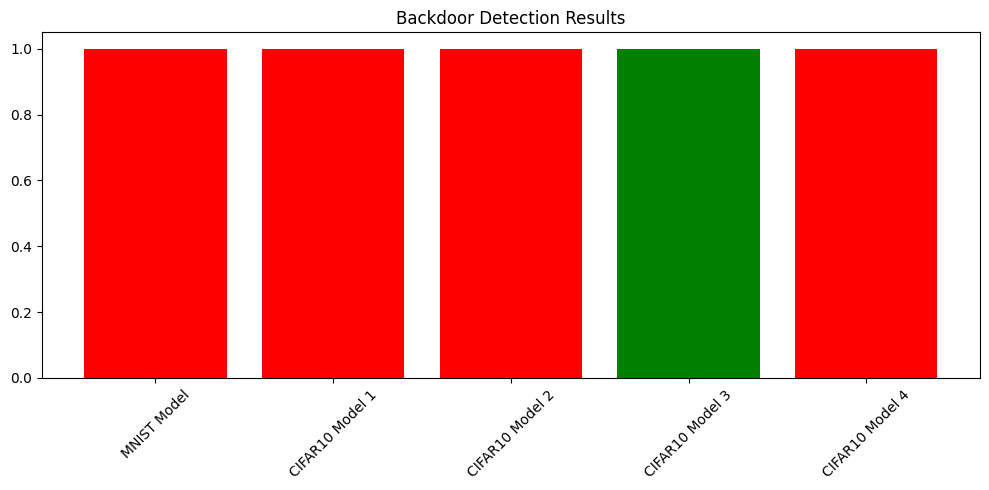

In [4]:
# Load models
print("Loading models...")
model_states = []
model_paths = [
    '/content/drive/MyDrive/SMU_MITB_AISE/Grp_Project/backdoor_cs612/model1/mnist_bd.pt',
    '/content/drive/MyDrive/SMU_MITB_AISE/Grp_Project/backdoor_cs612/model2/cifar10_bd.pt',
    '/content/drive/MyDrive/SMU_MITB_AISE/Grp_Project/backdoor_cs612/model3/cifar10_bd.pt',
    '/content/drive/MyDrive/SMU_MITB_AISE/Grp_Project/backdoor_cs612/model4/cifar10_bd.pt',
    '/content/drive/MyDrive/SMU_MITB_AISE/Grp_Project/backdoor_cs612/model5/cifar10_bd.pt'
]

for path in tqdm(model_paths, desc="Loading models"):
    model_states.append(torch.load(path, weights_only=True))

# Create and initialize models
models = []
model_configs = [
    {
        'arch': MNISTNet,
        'name': 'MNIST Model',
        'dataset': 'mnist',
        'num_classes': 10,
        'input_size': (1, 28, 28)
    },
    {
        'arch': CIFAR10Net,
        'name': 'CIFAR10 Model 1',
        'dataset': 'cifar10',
        'num_classes': 10,
        'input_size': (3, 32, 32)
    },
    {
        'arch': CIFAR10Net,
        'name': 'CIFAR10 Model 2',
        'dataset': 'cifar10',
        'num_classes': 10,
        'input_size': (3, 32, 32)
    },
    {
        'arch': CIFAR10Net,
        'name': 'CIFAR10 Model 3',
        'dataset': 'cifar10',
        'num_classes': 10,
        'input_size': (3, 32, 32)
    },
    {
        'arch': CIFAR10Net,
        'name': 'CIFAR10 Model 4',
        'dataset': 'cifar10',
        'num_classes': 10,
        'input_size': (3, 32, 32)
    }
]

# Initialize models
print("\nInitializing models...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for state, config in tqdm(zip(model_states, model_configs), desc="Initializing models", total=len(model_states)):
    model = config['arch']()
    model.load_state_dict(state)
    model.eval()
    models.append(model)

# Evaluate all models
print("\nStarting evaluation...")
results = []
for model, config in zip(models, model_configs):
    result = evaluate_model(
        model=model,
        name=config['name'],
        dataset=config['dataset'],
        num_classes=config['num_classes'],
        input_size=config['input_size'],
        device=device
    )
    results.append(result)
    print(f"Results for {result['name']}:")
    print(f"Backdoored: {result['is_backdoored']}")
    print(f"Target Class: {result['target_class']}\n")

# Visualize results
visualize_results(results)